### 3. Use Gibbs Sampling

In [1]:
import numpy as np

In [2]:
import numpy as np
from itertools import product

# Function to calculate the sum of neighbors for a given node in the lattice
def calculate_neighbors_sum(lattice, i, j, n, use_periodic_boundary):
    if use_periodic_boundary:
        # If periodic boundary conditions are used, the grid is wrapped around like a torus
        return (
            lattice[(i+1)%n, j] +  # Down neighbor
            lattice[i, (j+1)%n] +  # Right neighbor
            lattice[(i-1)%n, j] +  # Up neighbor
            lattice[i, (j-1)%n]    # Left neighbor
        )
    else:
        # If fixed boundary conditions are used, edges and corners have fewer neighbors
        neighbors = 0
        if i > 0: neighbors += lattice[i-1, j]  # Neighbor above, if not on top edge
        if i < n-1: neighbors += lattice[i+1, j]  # Neighbor below, if not on bottom edge
        if j > 0: neighbors += lattice[i, j-1]  # Neighbor to the left, if not on left edge
        if j < n-1: neighbors += lattice[i, j+1]  # Neighbor to the right, if not on right edge
        return neighbors

# Function to calculate the conditional probability of a spin being up or down
def conditional_probability(beta, s, neighbors_sum, num_neighbors):
    # Calculate the normalized sum of neighboring spins
    normalized_sum = neighbors_sum / num_neighbors
    # Calculate the conditional probability using the Boltzmann distribution
    return np.exp(beta * s * normalized_sum) / (
        np.exp(beta * normalized_sum) + np.exp(-beta * normalized_sum)
    )

# Function to perform Gibbs sampling over the lattice
def gibbs_sampling(lattice, beta, n, iterations, use_periodic_boundary):
    # Initialize a matrix to store the joint probabilities of the lattice
    joint_probabilities = np.zeros((2, 2))
    for _ in range(iterations):
        # Iterate over each node in the lattice
        for i, j in product(range(n), repeat=2):
            # Assume 4 neighbors for nodes not on edges or corners
            num_neighbors = 4
            # Calculate sum of neighbors for the current node
            neighbors_sum = calculate_neighbors_sum(lattice, i, j, n, use_periodic_boundary)
            # Calculate conditional probability for the node to be in the up state
            p_plus = conditional_probability(beta, +1, neighbors_sum, num_neighbors)
            # Update the node's state based on the conditional probability
            lattice[i, j] = 1 if np.random.rand() < p_plus else -1

        # After a burn-in period, start accumulating joint probabilities. The first hald of iterations were used as a burn-in period.            
        if _ > iterations // 2:
            # Increment the count for the current state of nodes x_{1,10} and x_{10,10}
            joint_probabilities[(lattice[1, n-1] + 1) // 2, (lattice[n-1, n-1] + 1) // 2] += 1

    # Normalize the joint probabilities
    joint_probabilities /= joint_probabilities.sum()
    return joint_probabilities

# Simulation parameters
n = 10  # Size of the lattice (10x10)
beta_values = [4, 3.5, 3, 2, 1.5, 1, 0.7, 0.5, 0.1, 0.01]  # List of beta values to simulate
iterations = 200000  # Number of iterations for the Gibbs sampling
use_periodic_boundary = False  # Flag to determine boundary condition type

# Perform Gibbs sampling for each beta value
for beta in beta_values:
    # Initialize the lattice with random spins
    initial_lattice = np.random.choice([-1, 1], size=(n, n))
    # Perform Gibbs sampling to calculate joint probabilities
    joint_probabilities = gibbs_sampling(initial_lattice, beta, n, iterations, use_periodic_boundary)
    # Print out the joint probabilities for the current beta value
    print(f"Joint probabilities for beta = {beta}:\n{joint_probabilities}\n")


Joint probabilities for beta = 4:
[[9.68859689e-01 2.43202432e-02]
 [6.67006670e-03 1.50001500e-04]]

Joint probabilities for beta = 3.5:
[[6.20006200e-04 1.55101551e-02]
 [4.46504465e-02 9.39219392e-01]]

Joint probabilities for beta = 3:
[[0.8804388  0.07948079]
 [0.03673037 0.00335003]]

Joint probabilities for beta = 2:
[[0.29459295 0.21113211]
 [0.20815208 0.28612286]]

Joint probabilities for beta = 1.5:
[[0.25132251 0.24761248]
 [0.24715247 0.25391254]]

Joint probabilities for beta = 1:
[[0.24796248 0.24886249]
 [0.25125251 0.25192252]]

Joint probabilities for beta = 0.7:
[[0.2498625  0.24868249]
 [0.25094251 0.25051251]]

Joint probabilities for beta = 0.5:
[[0.24661247 0.25254253]
 [0.25266253 0.24818248]]

Joint probabilities for beta = 0.1:
[[0.24781248 0.24943249]
 [0.2497725  0.25298253]]

Joint probabilities for beta = 0.01:
[[0.24936249 0.25099251]
 [0.24796248 0.25168252]]



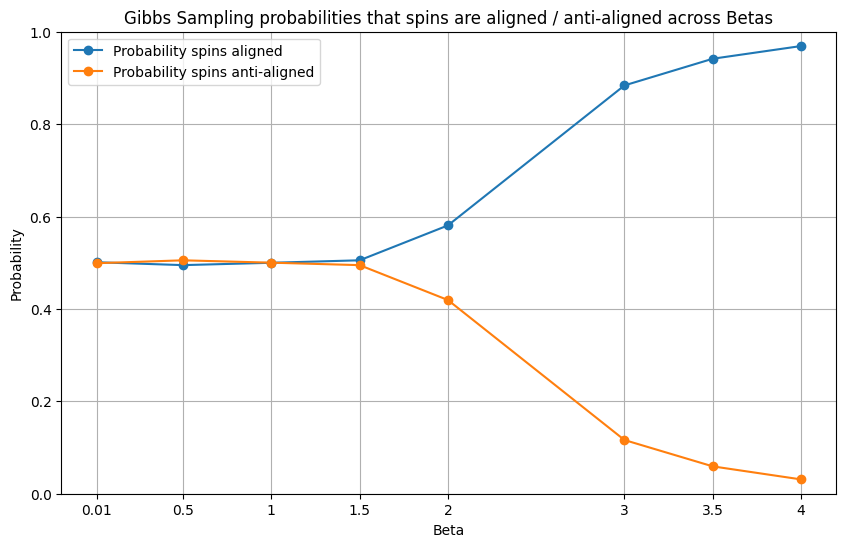

In [5]:
import matplotlib.pyplot as plt
import numpy as np 

beta_values = [4, 3, 2, 1.5, 1, 0.5, 0.01]
probability_tables = {
    4: np.array([[9.68859689e-01 ,2.43202432e-02], [6.67006670e-03 ,1.50001500e-04]]),
    3.5: np.array([[0.9406, 0.0296], [0.0296, 0.00093]]),
    3: np.array([[0.8804388  ,0.07948079], [0.03673037 ,0.00335003]]),
   # 2.5: np.array([[0.8325, 0.07989], [0.0798, 0.00766]]),
    2: np.array([[0.29459295 ,0.21113211], [0.20815208, 0.28612286]]),
    1.5: np.array([[0.25132251, 0.24761248], [0.24715247 ,0.25391254]]),
    1: np.array([[0.24796248 ,0.24886249], [0.25125251 ,0.25192252]]),
    0.5: np.array([[0.24661247 ,0.25254253], [0.25266253, 0.24818248]]),
    0.01: np.array([[0.24936249, 0.25099251], [0.24796248 ,0.25168252]]), }

beta_values = sorted(probability_tables.keys())
aligned_probabilities = [probability_tables[beta][0, 0] + probability_tables[beta][1, 1] for beta in beta_values]
anti_aligned_probabilities = [probability_tables[beta][0, 1] + probability_tables[beta][1, 0] for beta in beta_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(beta_values, aligned_probabilities, 'o-', label='Probability spins aligned')
plt.plot(beta_values, anti_aligned_probabilities, 'o-', label='Probability spins anti-aligned')
plt.xlabel('Beta')
plt.ylabel('Probability')
plt.title('Gibbs Sampling probabilities that spins are aligned / anti-aligned across Betas')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.0)  # Establece el límite del eje y de 0 a 1.0
plt.xticks(beta_values, beta_values)  # Asegúrate de que todos los valores de beta se muestren en el eje x
plt.show()